# IMDb Data Analysis with SQL and Visualization with Python

## Introduction

The goal of this project is to analyze IMDb data taken from the official website and draw meaningful insights based on the information. Datasets were taken from https://www.imdb.com/interfaces/ on 1/22/2020 and then imported into a SQLite database.

To do so, we will be using SQL as our primary data anlysis tool and Python as our primary data visualization tool.

## Importing Libraries and Setting Up

We will be utilizing SQL commands and visualizing data through Python libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

conn = sqlite3.connect('IMDb.db')

## Overview of Database Schema

Now we would like to examine the schema of our database.


In [2]:
tables = pd.read_sql("""
SELECT *
FROM sqlite_master
WHERE type = 'table';
""", conn)

tables

,type,name,tbl_name,rootpage,sql
0,table,title_basics_data,title_basics_data,2,"CREATE TABLE ""title_basics_data"" (\n\t""tconst""..."
1,table,title_ratings_data,title_ratings_data,144617,"CREATE TABLE ""title_ratings_data"" (\n\t""tconst..."


## Overview of Tables

Now we would like to examine each individual table within the database.

In [3]:
title_basics_overview = pd.read_sql("""
SELECT *
FROM title_basics_data
LIMIT 5;
""", conn)

title_basics_overview

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,\N,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [4]:
title_ratings_overview = pd.read_sql("""
SELECT *
FROM title_ratings_data
LIMIT 5;
""", conn)

title_ratings_overview

,tconst,averageRating,numVotes
0,tt0000001,5.6,1575
1,tt0000002,6.1,189
2,tt0000003,6.5,1239
3,tt0000004,6.2,117
4,tt0000005,6.1,1981


## Modifying the Data

Let's start modifying the data.

In [7]:
distinct_title_types = pd.read_sql("""
SELECT DISTINCT titleType
FROM title_basics_data;
""", conn)

distinct_title_types

,titleType
0,short
1,movie
2,tvMovie
3,tvSeries
4,tvEpisode
5,tvShort
6,tvMiniSeries
7,tvSpecial
8,video
9,videoGame


Since we are interested in 2019 blockbuster movies, we will query for 2019 movies with at least 1,000 votes.

In [8]:
movies_2019 = pd.read_sql("""
SELECT tb.tconst, primaryTitle, startYear, genres, averageRating, numVotes
FROM title_basics_data AS 'tb'
JOIN title_ratings_data AS 'tr'
    ON tb.tconst = tr.tconst
WHERE titleType = 'movie'
    AND startYear = 2019
    AND numVotes >= 1000
ORDER BY averageRating DESC;
""", conn)

movies_2019

,tconst,primaryTitle,startYear,genres,averageRating,numVotes
0,tt6735740,Love in Kilnerry,2019,Comedy,9.9,2955
1,tt7535666,Retrocausality,2019,"Drama,Romance",9.5,1697
2,tt8354112,Mosul,2019,Documentary,9.1,2690
3,tt9185066,Human Capital,2019,Drama,9.1,1602
4,tt5593384,Truth and Justice,2019,Drama,9.0,1849
...,...,...,...,...,...,...
626,tt6593054,Drive,2019,"Action,Thriller",2.4,2826
627,tt7399138,Recep Ivedik 6,2019,Comedy,2.4,1413
628,tt4058836,I Spit on Your Grave: Deja Vu,2019,"Horror,Thriller",2.3,1402
629,tt9783778,Adventures of Aladdin,2019,"Adventure,Fantasy",1.7,1043


Result is 631 movies. Let's limit the query to movies with at least 10,000 votes to filter for blockbuster movies.

In [9]:
blockbuster_movies_2019 = pd.read_sql("""
SELECT tb.tconst, primaryTitle, startYear, genres, averageRating, numVotes
FROM title_basics_data AS 'tb'
JOIN title_ratings_data AS 'tr'
    ON tb.tconst = tr.tconst
WHERE titleType = 'movie'
    AND startYear = 2019
    AND numVotes >= 10000
ORDER BY averageRating DESC;
""", conn)

blockbuster_movies_2019

,tconst,primaryTitle,startYear,genres,averageRating,numVotes
0,tt6751668,Parasite,2019,"Comedy,Crime,Drama",8.6,159446
1,tt7286456,Joker,2019,"Crime,Drama,Thriller",8.6,622678
2,tt8579674,1917,2019,"Drama,War",8.6,73360
3,tt4154796,Avengers: Endgame,2019,"Action,Adventure,Drama",8.5,650218
4,tt8291224,Uri: The Surgical Strike,2019,"Action,Drama,War",8.4,36694
...,...,...,...,...,...,...
165,tt5033998,Charlie's Angels,2019,"Action,Adventure,Comedy",4.2,17757
166,tt5913798,Wounds,2019,"Drama,Horror,Mystery",4.1,10820
167,tt7825208,Marighella,2019,"Action,Drama,History",3.0,42321
168,tt5697572,Cats,2019,"Comedy,Drama,Family",2.8,23213


Result is 170 movies with much more recognizable titles. Let's clean up the data and split the `genres` column. CASE statements are necessary to maintain ordering of genres, in addition to subqueries and common table expressions.

In [10]:
clean_blockbuster_movies_2019 = pd.read_sql("""
WITH blockbuster_movies_2019 AS (
    SELECT tb.tconst, primaryTitle, startYear, genres, averageRating, numVotes
    FROM title_basics_data AS 'tb'
    JOIN title_ratings_data AS 'tr'
        ON tb.tconst = tr.tconst
    WHERE titleType = 'movie'
        AND startYear = 2019
        AND numVotes >= 10000
    ORDER BY averageRating DESC
),
clean_blockbuster_movies_2019 AS (
    SELECT tconst AS 'title_id', primaryTitle AS 'primary_title', startYear AS 'year',
        averageRating AS 'average_rating', numVotes AS 'num_votes', genre_1,
        CASE
            WHEN INSTR(genre_2_3, ',') = 0 THEN genre_2_3
            ELSE SUBSTR(genre_2_3, 1, INSTR(genre_2_3, ',') - 1)
        END AS 'genre_2',
        CASE
            WHEN INSTR(genre_2_3, ',') > 0 THEN SUBSTR(genre_2_3, INSTR(genre_2_3, ',') + 1)
        END AS 'genre_3'
    FROM (
        SELECT blockbuster_movies_2019.*,
            CASE
                WHEN INSTR(genres, ',') = 0 THEN genres
                ELSE SUBSTR(genres, 1, INSTR(genres, ',') - 1)
            END AS 'genre_1',
            CASE
                WHEN INSTR(genres, ',') >0 THEN SUBSTR(genres, INSTR(genres, ',') + 1)
            END AS 'genre_2_3'
    FROM blockbuster_movies_2019
    )
)
SELECT *
FROM clean_blockbuster_movies_2019;
""", conn)

clean_blockbuster_movies_2019

,title_id,primary_title,year,average_rating,num_votes,genre_1,genre_2,genre_3
0,tt6751668,Parasite,2019,8.6,159446,Comedy,Crime,Drama
1,tt7286456,Joker,2019,8.6,622678,Crime,Drama,Thriller
2,tt8579674,1917,2019,8.6,73360,Drama,War,None
3,tt4154796,Avengers: Endgame,2019,8.5,650218,Action,Adventure,Drama
4,tt8291224,Uri: The Surgical Strike,2019,8.4,36694,Action,Drama,War
...,...,...,...,...,...,...,...,...
165,tt5033998,Charlie's Angels,2019,4.2,17757,Action,Adventure,Comedy
166,tt5913798,Wounds,2019,4.1,10820,Drama,Horror,Mystery
167,tt7825208,Marighella,2019,3.0,42321,Action,Drama,History
168,tt5697572,Cats,2019,2.8,23213,Comedy,Drama,Family


## Basic Analysis

We will be utilizing the previous common table expression moving forward in our analyses.

First, we will find the minimum, maximum, and average ratings.

In [11]:
min_max_avg_ratings_blockbuster_movies_2019 = pd.read_sql("""
WITH blockbuster_movies_2019 AS (
    SELECT tb.tconst, primaryTitle, startYear, genres, averageRating, numVotes
    FROM title_basics_data AS 'tb'
    JOIN title_ratings_data AS 'tr'
        ON tb.tconst = tr.tconst
    WHERE titleType = 'movie'
        AND startYear = 2019
        AND numVotes >= 10000
    ORDER BY averageRating DESC
),
clean_blockbuster_movies_2019 AS (
    SELECT tconst AS 'title_id', primaryTitle AS 'primary_title', startYear AS 'year',
        averageRating AS 'average_rating', numVotes AS 'num_votes', genre_1,
        CASE
            WHEN INSTR(genre_2_3, ',') = 0 THEN genre_2_3
            ELSE SUBSTR(genre_2_3, 1, INSTR(genre_2_3, ',') - 1)
        END AS 'genre_2',
        CASE
            WHEN INSTR(genre_2_3, ',') > 0 THEN SUBSTR(genre_2_3, INSTR(genre_2_3, ',') + 1)
        END AS 'genre_3'
    FROM (
        SELECT blockbuster_movies_2019.*,
            CASE
                WHEN INSTR(genres, ',') = 0 THEN genres
                ELSE SUBSTR(genres, 1, INSTR(genres, ',') - 1)
            END AS 'genre_1',
            CASE
                WHEN INSTR(genres, ',') >0 THEN SUBSTR(genres, INSTR(genres, ',') + 1)
            END AS 'genre_2_3'
    FROM blockbuster_movies_2019
    )
)
SELECT MIN(average_rating) AS 'min_rating', MAX(average_rating) as 'max_rating',
    ROUND(AVG(average_rating), 2) AS 'avg_rating'
FROM clean_blockbuster_movies_2019;
""", conn)

min_max_avg_ratings_blockbuster_movies_2019

,min_rating,max_rating,avg_rating
0,2.5,8.6,6.61


Finding the top 5 best and worst movies of 2019.

In [12]:
top_blockbuster_movies_2019 = pd.read_sql("""
WITH blockbuster_movies_2019 AS (
    SELECT tb.tconst, primaryTitle, startYear, genres, averageRating, numVotes
    FROM title_basics_data AS 'tb'
    JOIN title_ratings_data AS 'tr'
        ON tb.tconst = tr.tconst
    WHERE titleType = 'movie'
        AND startYear = 2019
        AND numVotes >= 10000
    ORDER BY averageRating DESC
),
clean_blockbuster_movies_2019 AS (
    SELECT tconst AS 'title_id', primaryTitle AS 'primary_title', startYear AS 'year',
        averageRating AS 'average_rating', numVotes AS 'num_votes', genre_1,
        CASE
            WHEN INSTR(genre_2_3, ',') = 0 THEN genre_2_3
            ELSE SUBSTR(genre_2_3, 1, INSTR(genre_2_3, ',') - 1)
        END AS 'genre_2',
        CASE
            WHEN INSTR(genre_2_3, ',') > 0 THEN SUBSTR(genre_2_3, INSTR(genre_2_3, ',') + 1)
        END AS 'genre_3'
    FROM (
        SELECT blockbuster_movies_2019.*,
            CASE
                WHEN INSTR(genres, ',') = 0 THEN genres
                ELSE SUBSTR(genres, 1, INSTR(genres, ',') - 1)
            END AS 'genre_1',
            CASE
                WHEN INSTR(genres, ',') >0 THEN SUBSTR(genres, INSTR(genres, ',') + 1)
            END AS 'genre_2_3'
    FROM blockbuster_movies_2019
    )
)
SELECT *
FROM clean_blockbuster_movies_2019
LIMIT 5;
""", conn)

top_blockbuster_movies_2019

,title_id,primary_title,year,average_rating,num_votes,genre_1,genre_2,genre_3
0,tt6751668,Parasite,2019,8.6,159446,Comedy,Crime,Drama
1,tt7286456,Joker,2019,8.6,622678,Crime,Drama,Thriller
2,tt8579674,1917,2019,8.6,73360,Drama,War,None
3,tt4154796,Avengers: Endgame,2019,8.5,650218,Action,Adventure,Drama
4,tt8291224,Uri: The Surgical Strike,2019,8.4,36694,Action,Drama,War


In [14]:
bottom_blockbuster_movies_2019 = pd.read_sql("""
WITH blockbuster_movies_2019 AS (
    SELECT tb.tconst, primaryTitle, startYear, genres, averageRating, numVotes
    FROM title_basics_data AS 'tb'
    JOIN title_ratings_data AS 'tr'
        ON tb.tconst = tr.tconst
    WHERE titleType = 'movie'
        AND startYear = 2019
        AND numVotes >= 10000
    ORDER BY averageRating DESC
),
clean_blockbuster_movies_2019 AS (
    SELECT tconst AS 'title_id', primaryTitle AS 'primary_title', startYear AS 'year',
        averageRating AS 'average_rating', numVotes AS 'num_votes', genre_1,
        CASE
            WHEN INSTR(genre_2_3, ',') = 0 THEN genre_2_3
            ELSE SUBSTR(genre_2_3, 1, INSTR(genre_2_3, ',') - 1)
        END AS 'genre_2',
        CASE
            WHEN INSTR(genre_2_3, ',') > 0 THEN SUBSTR(genre_2_3, INSTR(genre_2_3, ',') + 1)
        END AS 'genre_3'
    FROM (
        SELECT blockbuster_movies_2019.*,
            CASE
                WHEN INSTR(genres, ',') = 0 THEN genres
                ELSE SUBSTR(genres, 1, INSTR(genres, ',') - 1)
            END AS 'genre_1',
            CASE
                WHEN INSTR(genres, ',') >0 THEN SUBSTR(genres, INSTR(genres, ',') + 1)
            END AS 'genre_2_3'
    FROM blockbuster_movies_2019
    )
)
SELECT *
FROM clean_blockbuster_movies_2019
ORDER BY average_rating ASC
LIMIT 5;
""", conn)

bottom_blockbuster_movies_2019

,title_id,primary_title,year,average_rating,num_votes,genre_1,genre_2,genre_3
0,tt7255568,Student of the Year 2,2019,2.5,13050,Drama,Romance,Sport
1,tt5697572,Cats,2019,2.8,23213,Comedy,Drama,Family
2,tt7825208,Marighella,2019,3.0,42321,Action,Drama,History
3,tt5913798,Wounds,2019,4.1,10820,Drama,Horror,Mystery
4,tt5033998,Charlie's Angels,2019,4.2,17757,Action,Adventure,Comedy


## Analysis and Visualization of Ratings

We will begin by creating a histogram of ratings.

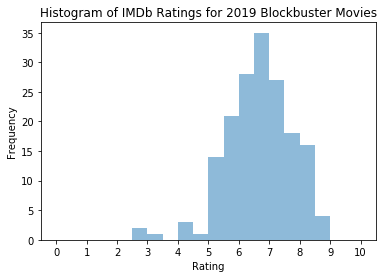

In [57]:
ax = plt.subplot()
plt.hist(clean_blockbuster_movies_2019.average_rating, range=(0, 10), bins=20, alpha=0.5)
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
ax.set_xlabel('Rating')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of IMDb Ratings for 2019 Blockbuster Movies')
plt.show()

Now we'll calculate some basic statistics for our dataset. We will set alpha = 0.05 for our statistical testing.

In [86]:
print("The mean of our dataset is {0}".format(np.mean(clean_blockbuster_movies_2019.average_rating)))
print("The minimum value of our dataset is {0}".format(np.amin(clean_blockbuster_movies_2019.average_rating)))
print("The first quartile of our dataset is {0}".format(np.quantile(clean_blockbuster_movies_2019.average_rating, 0.25)))
print("The median of our dataset is {0}".format(np.median(clean_blockbuster_movies_2019.average_rating)))
print("The third quartile of our dataset is {0}".format(np.quantile(clean_blockbuster_movies_2019.average_rating, 0.75)))
print("The maximum value of our dataset is {0}".format(np.amax(clean_blockbuster_movies_2019.average_rating)))
print("The standard deviation of our dataset is {0}".format(np.std(clean_blockbuster_movies_2019.average_rating)))

The mean of our dataset is 6.613529411764708
The minimum value of our dataset is 2.5
The first quartile of our dataset is 6.0
The median of our dataset is 6.7
The third quartile of our dataset is 7.3
The maximum value of our dataset is 8.6
The standard deviation of our dataset is 1.072322609360967


## Analysis and Visualization of Genres

Gather all genres.

In [89]:
distinct_genres_blockbuster_movies_2019 = pd.read_sql("""
WITH blockbuster_movies_2019 AS (
    SELECT tb.tconst, primaryTitle, startYear, genres, averageRating, numVotes
    FROM title_basics_data AS 'tb'
    JOIN title_ratings_data AS 'tr'
        ON tb.tconst = tr.tconst
    WHERE titleType = 'movie'
        AND startYear = 2019
        AND numVotes >= 10000
    ORDER BY averageRating DESC
),
clean_blockbuster_movies_2019 AS (
    SELECT tconst AS 'title_id', primaryTitle AS 'primary_title', startYear AS 'year',
        averageRating AS 'average_rating', numVotes AS 'num_votes', genre_1,
        CASE
            WHEN INSTR(genre_2_3, ',') = 0 THEN genre_2_3
            ELSE SUBSTR(genre_2_3, 1, INSTR(genre_2_3, ',') - 1)
        END AS 'genre_2',
        CASE
            WHEN INSTR(genre_2_3, ',') > 0 THEN SUBSTR(genre_2_3, INSTR(genre_2_3, ',') + 1)
        END AS 'genre_3'
    FROM (
        SELECT blockbuster_movies_2019.*,
            CASE
                WHEN INSTR(genres, ',') = 0 THEN genres
                ELSE SUBSTR(genres, 1, INSTR(genres, ',') - 1)
            END AS 'genre_1',
            CASE
                WHEN INSTR(genres, ',') >0 THEN SUBSTR(genres, INSTR(genres, ',') + 1)
            END AS 'genre_2_3'
    FROM blockbuster_movies_2019
    )
)
SELECT genre_1 AS 'genres'
FROM clean_blockbuster_movies_2019
WHERE genre_1 IS NOT NULL
UNION
SELECT genre_2
FROM clean_blockbuster_movies_2019
WHERE genre_2 IS NOT NULL
UNION
SELECT genre_3
FROM clean_blockbuster_movies_2019
WHERE genre_3 IS NOT NULL;
""", conn)

distinct_genres_blockbuster_movies_2019

,genres
0,Action
1,Adventure
2,Animation
3,Biography
4,Comedy
5,Crime
6,Documentary
7,Drama
8,Family
9,Fantasy


19 total distinct genres from 2019 blockbuster movies. Gather and count all genres to analyze.

In [104]:
count_genres_blockbuster_movies_2019 = pd.read_sql("""
WITH blockbuster_movies_2019 AS (
    SELECT tb.tconst, primaryTitle, startYear, genres, averageRating, numVotes
    FROM title_basics_data AS 'tb'
    JOIN title_ratings_data AS 'tr'
        ON tb.tconst = tr.tconst
    WHERE titleType = 'movie'
        AND startYear = 2019
        AND numVotes >= 10000
    ORDER BY averageRating DESC
),
clean_blockbuster_movies_2019 AS (
    SELECT tconst AS 'title_id', primaryTitle AS 'primary_title', startYear AS 'year',
        averageRating AS 'average_rating', numVotes AS 'num_votes', genre_1,
        CASE
            WHEN INSTR(genre_2_3, ',') = 0 THEN genre_2_3
            ELSE SUBSTR(genre_2_3, 1, INSTR(genre_2_3, ',') - 1)
        END AS 'genre_2',
        CASE
            WHEN INSTR(genre_2_3, ',') > 0 THEN SUBSTR(genre_2_3, INSTR(genre_2_3, ',') + 1)
        END AS 'genre_3'
    FROM (
        SELECT blockbuster_movies_2019.*,
            CASE
                WHEN INSTR(genres, ',') = 0 THEN genres
                ELSE SUBSTR(genres, 1, INSTR(genres, ',') - 1)
            END AS 'genre_1',
            CASE
                WHEN INSTR(genres, ',') >0 THEN SUBSTR(genres, INSTR(genres, ',') + 1)
            END AS 'genre_2_3'
    FROM blockbuster_movies_2019
    )
),
all_genres_blockbuster_movies_2019 AS (
    SELECT genre_1 AS 'genres'
    FROM clean_blockbuster_movies_2019
    WHERE genre_1 IS NOT NULL
    UNION ALL
    SELECT genre_2
    FROM clean_blockbuster_movies_2019
    WHERE genre_2 IS NOT NULL
    UNION ALL
    SELECT genre_3
    FROM clean_blockbuster_movies_2019
    WHERE genre_3 IS NOT NULL
)
SELECT genres, COUNT(*) AS 'count'
FROM all_genres_blockbuster_movies_2019
GROUP BY 1
ORDER BY 2 DESC;
""", conn)

count_genres_blockbuster_movies_2019

,genres,count
0,Drama,89
1,Comedy,61
2,Action,46
3,Adventure,44
4,Horror,28
5,Crime,25
6,Thriller,22
7,Romance,22
8,Biography,22
9,Mystery,21


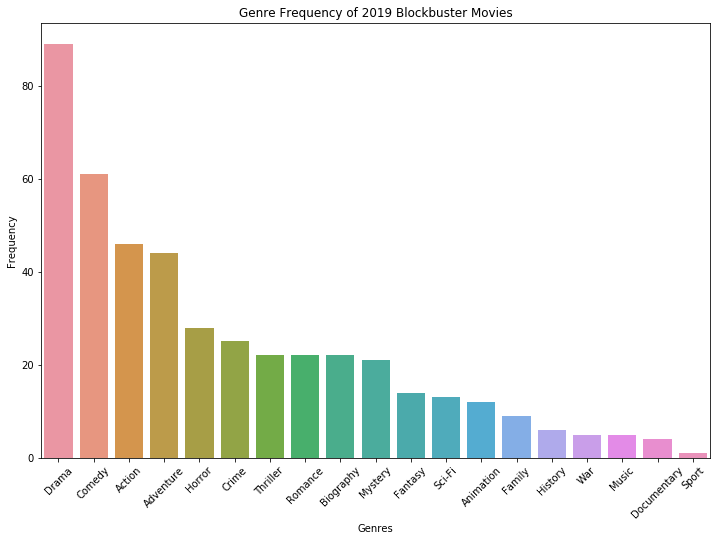

In [217]:
plt.figure(figsize=(12, 8))
ax = plt.subplot()
sns.barplot(data=count_genres_blockbuster_movies_2019, x='genres', y='count')
plt.xticks(rotation=45)
ax.set_xlabel('Genres')
ax.set_ylabel('Frequency')
ax.set_title('Genre Frequency of 2019 Blockbuster Movies')
plt.show()

Try to get average rating of genres

In [317]:
genre_ratings_blockbuster_movies_2019 = pd.read_sql("""
WITH blockbuster_movies_2019 AS (
    SELECT tb.tconst, primaryTitle, startYear, genres, averageRating, numVotes
    FROM title_basics_data AS 'tb'
    JOIN title_ratings_data AS 'tr'
        ON tb.tconst = tr.tconst
    WHERE titleType = 'movie'
        AND startYear = 2019
        AND numVotes >= 10000
    ORDER BY averageRating DESC
),
clean_blockbuster_movies_2019 AS (
    SELECT tconst AS 'title_id', primaryTitle AS 'primary_title', startYear AS 'year',
        averageRating AS 'average_rating', numVotes AS 'num_votes', genre_1,
        CASE
            WHEN INSTR(genre_2_3, ',') = 0 THEN genre_2_3
            ELSE SUBSTR(genre_2_3, 1, INSTR(genre_2_3, ',') - 1)
        END AS 'genre_2',
        CASE
            WHEN INSTR(genre_2_3, ',') > 0 THEN SUBSTR(genre_2_3, INSTR(genre_2_3, ',') + 1)
        END AS 'genre_3'
    FROM (
        SELECT blockbuster_movies_2019.*,
            CASE
                WHEN INSTR(genres, ',') = 0 THEN genres
                ELSE SUBSTR(genres, 1, INSTR(genres, ',') - 1)
            END AS 'genre_1',
            CASE
                WHEN INSTR(genres, ',') >0 THEN SUBSTR(genres, INSTR(genres, ',') + 1)
            END AS 'genre_2_3'
    FROM blockbuster_movies_2019
    )
),
union_genre_ratings_blockbuster_movies_2019 AS (
    SELECT genre_1 AS 'genres', AVG(average_rating) AS 'average_rating', COUNT(*) AS 'count'
    FROM clean_blockbuster_movies_2019
    WHERE genre_1 IS NOT NULL
    GROUP BY 1
    UNION ALL
    SELECT genre_2, AVG(average_rating), COUNT(*) AS 'count'
    FROM clean_blockbuster_movies_2019
    WHERE genre_2 IS NOT NULL
    GROUP BY 1
    UNION ALL
    SELECT genre_3, AVG(average_rating), COUNT(*) AS 'count'
    FROM clean_blockbuster_movies_2019
    WHERE genre_3 IS NOT NULL
    GROUP BY 1
)
SELECT genres, ROUND(AVG(average_rating), 2) AS 'average_rating', SUM(count) AS 'count'
FROM union_genre_ratings_blockbuster_movies_2019
GROUP BY 1
ORDER BY 2 DESC;
""", conn)

genre_ratings_blockbuster_movies_2019

,genres,average_rating,count
0,War,7.99,5
1,Music,7.38,5
2,Documentary,7.35,4
3,Biography,7.33,22
4,Crime,6.97,25
5,Animation,6.95,12
6,Drama,6.87,89
7,History,6.75,6
8,Comedy,6.58,61
9,Adventure,6.57,44


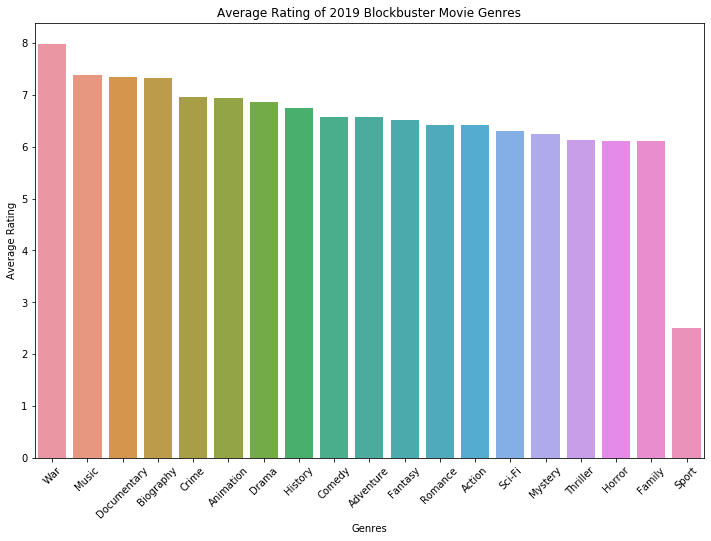

In [168]:
plt.figure(figsize=(12, 8))
ax = plt.subplot()
sns.barplot(data=genre_ratings_blockbuster_movies_2019, x='genres', y='average_rating')
plt.xticks(rotation=45)
ax.set_xlabel('Genres')
ax.set_ylabel('Average Rating')
ax.set_title('Average Rating of 2019 Blockbuster Movie Genres')
plt.show()

Although this is an accurate visualization of 2019 blockbuster movie genre ratings, it does not accurately show the true average ratings of blockbuster movie genres in general since the sample size for many of the genres is far too small.

Let's try a multi-year analysis.

## Multi-Year Analysis

Gathering data for multi-year analysis.

In [305]:
clean_blockbuster_movies_multi_year = pd.read_sql("""
WITH blockbuster_movies_multi_year AS (
    SELECT tb.tconst, primaryTitle, startYear, genres, averageRating, numVotes
    FROM title_basics_data AS 'tb'
    JOIN title_ratings_data AS 'tr'
        ON tb.tconst = tr.tconst
    WHERE titleType = 'movie'
        AND startYear BETWEEN 2010 AND 2019
        AND numVotes >= 10000
    ORDER BY averageRating DESC
),
clean_blockbuster_movies_multi_year AS (
    SELECT tconst AS 'title_id', primaryTitle AS 'primary_title', startYear AS 'year',
        averageRating AS 'average_rating', numVotes AS 'num_votes', genre_1,
        CASE
            WHEN INSTR(genre_2_3, ',') = 0 THEN genre_2_3
            ELSE SUBSTR(genre_2_3, 1, INSTR(genre_2_3, ',') - 1)
        END AS 'genre_2',
        CASE
            WHEN INSTR(genre_2_3, ',') > 0 THEN SUBSTR(genre_2_3, INSTR(genre_2_3, ',') + 1)
        END AS 'genre_3'
    FROM (
        SELECT blockbuster_movies_multi_year.*,
            CASE
                WHEN INSTR(genres, ',') = 0 THEN genres
                ELSE SUBSTR(genres, 1, INSTR(genres, ',') - 1)
            END AS 'genre_1',
            CASE
                WHEN INSTR(genres, ',') >0 THEN SUBSTR(genres, INSTR(genres, ',') + 1)
            END AS 'genre_2_3'
    FROM blockbuster_movies_multi_year
    ORDER BY 3
    )
)
SELECT *
FROM clean_blockbuster_movies_multi_year;
""", conn)

clean_blockbuster_movies_multi_year

,title_id,primary_title,year,average_rating,num_votes,genre_1,genre_2,genre_3
0,tt1375666,Inception,2010,8.8,1914224,Action,Adventure,Sci-Fi
1,tt1424432,Senna,2010,8.5,58052,Biography,Documentary,Sport
2,tt0435761,Toy Story 3,2010,8.3,714835,Adventure,Animation,Comedy
3,tt1255953,Incendies,2010,8.3,131587,Drama,Mystery,War
4,tt1634013,Montevideo: Taste of a Dream,2010,8.2,10753,Adventure,Comedy,Drama
...,...,...,...,...,...,...,...,...
2882,tt5033998,Charlie's Angels,2019,4.2,17757,Action,Adventure,Comedy
2883,tt5913798,Wounds,2019,4.1,10820,Drama,Horror,Mystery
2884,tt7825208,Marighella,2019,3.0,42321,Action,Drama,History
2885,tt5697572,Cats,2019,2.8,23213,Comedy,Drama,Family


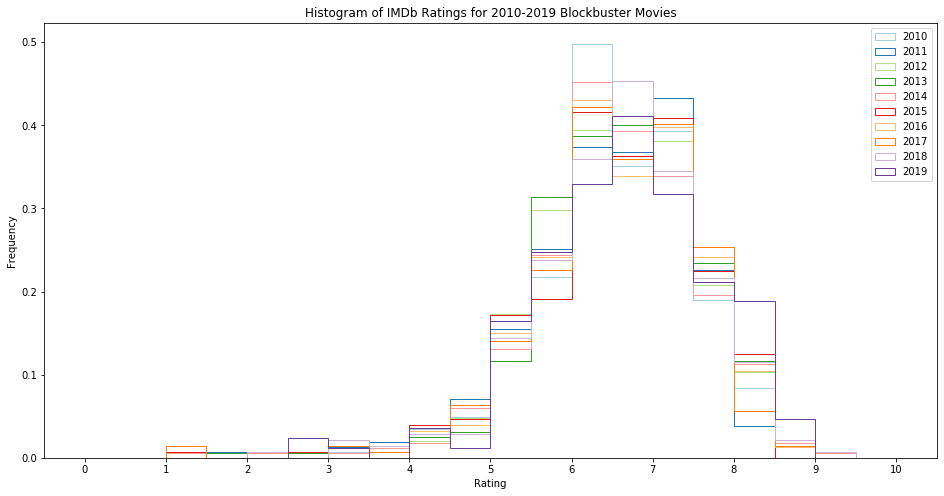

In [306]:
plt.figure(figsize=(16, 8))
ax = plt.subplot()
for i in range(2010, 2020):
    plt.hist(clean_blockbuster_movies_multi_year[clean_blockbuster_movies_multi_year.year == i]\
             .average_rating, range=(0, 10), bins=20, density=True, histtype='step', label=str(i))
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
ax.set_xlabel('Rating')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of IMDb Ratings for 2010-2019 Blockbuster Movies')
plt.legend()
plt.show()

Moving onto percentile analysis.

In [271]:
percentile_genres_blockbuster_movies_multi_year = pd.read_sql("""
WITH blockbuster_movies_multi_year AS (
    SELECT tb.tconst, primaryTitle, startYear, genres, averageRating, numVotes
    FROM title_basics_data AS 'tb'
    JOIN title_ratings_data AS 'tr'
        ON tb.tconst = tr.tconst
    WHERE titleType = 'movie'
        AND startYear BETWEEN 2010 AND 2019
        AND numVotes >= 10000
    ORDER BY averageRating DESC
),
clean_blockbuster_movies_multi_year AS (
    SELECT tconst AS 'title_id', primaryTitle AS 'primary_title', startYear AS 'year',
        averageRating AS 'average_rating', numVotes AS 'num_votes', genre_1,
        CASE
            WHEN INSTR(genre_2_3, ',') = 0 THEN genre_2_3
            ELSE SUBSTR(genre_2_3, 1, INSTR(genre_2_3, ',') - 1)
        END AS 'genre_2',
        CASE
            WHEN INSTR(genre_2_3, ',') > 0 THEN SUBSTR(genre_2_3, INSTR(genre_2_3, ',') + 1)
        END AS 'genre_3'
    FROM (
        SELECT blockbuster_movies_multi_year.*,
            CASE
                WHEN INSTR(genres, ',') = 0 THEN genres
                ELSE SUBSTR(genres, 1, INSTR(genres, ',') - 1)
            END AS 'genre_1',
            CASE
                WHEN INSTR(genres, ',') >0 THEN SUBSTR(genres, INSTR(genres, ',') + 1)
            END AS 'genre_2_3'
    FROM blockbuster_movies_multi_year
    ORDER BY 3
    )
),
all_genres_blockbuster_movies_multi_year AS (
    SELECT year, genre_1 AS 'genres', COUNT(*) AS 'count'
    FROM clean_blockbuster_movies_multi_year
    WHERE genre_1 IS NOT NULL
    GROUP BY 1, 2
    UNION ALL
    SELECT year, genre_2, COUNT(*)
    FROM clean_blockbuster_movies_multi_year
    WHERE genre_2 IS NOT NULL
    GROUP BY 1, 2
    UNION ALL
    SELECT year, genre_3, COUNT(*)
    FROM clean_blockbuster_movies_multi_year
    WHERE genre_3 IS NOT NULL
    GROUP BY 1, 2
    ORDER BY 1 ASC, 3 DESC
),
year_count_blockbuster_movies_multi_year AS (
    SELECT year, SUM(count) AS 'year_count'
    FROM all_genres_blockbuster_movies_multi_year
    GROUP BY 1
),
join_count_blockbuster_movies_multi_year AS (
    SELECT ag.year, ag.genres, SUM(ag.count) AS 'count', tc.year_count
    FROM all_genres_blockbuster_movies_multi_year AS 'ag'
    JOIN year_count_blockbuster_movies_multi_year AS 'tc'
        ON ag.year = tc.year
    GROUP BY 1, 2
    ORDER BY 1 ASC, 3 DESC
)
SELECT *, 1.0 * count / year_count AS 'percentile'
FROM join_count_blockbuster_movies_multi_year;
""", conn)

percentile_genres_blockbuster_movies_multi_year

,year,genres,count,year_count,percentile
0,2010,Drama,163,728,0.223901
1,2010,Comedy,109,728,0.149725
2,2010,Action,77,728,0.105769
3,2010,Romance,61,728,0.083791
4,2010,Crime,50,728,0.068681
...,...,...,...,...,...
204,2019,History,6,449,0.013363
205,2019,War,5,449,0.011136
206,2019,Music,5,449,0.011136
207,2019,Documentary,4,449,0.008909


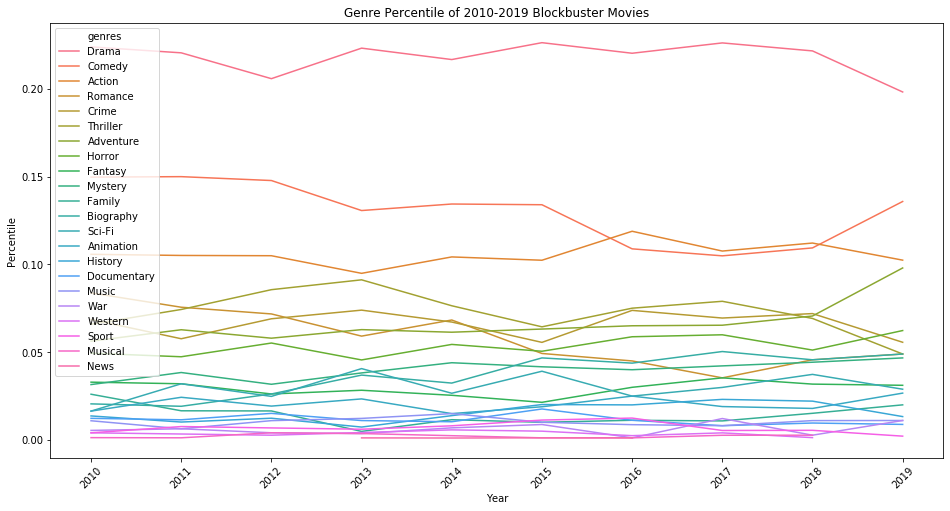

In [275]:
plt.figure(figsize=(16, 8))
ax = plt.subplot()
sns.lineplot(data=percentile_genres_blockbuster_movies_multi_year, x='year', y='percentile', hue='genres')
plt.xticks(rotation=45)
ax.set_xticks([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])
ax.set_xlabel('Year')
ax.set_ylabel('Percentile')
ax.set_title('Genre Percentile of 2010-2019 Blockbuster Movies')
plt.show()

Average genre ratings by year.

In [316]:
genre_ratings_blockbuster_movies_multi_year = pd.read_sql("""
WITH blockbuster_movies_multi_year AS (
    SELECT tb.tconst, primaryTitle, startYear, genres, averageRating, numVotes
    FROM title_basics_data AS 'tb'
    JOIN title_ratings_data AS 'tr'
        ON tb.tconst = tr.tconst
    WHERE titleType = 'movie'
        AND startYear BETWEEN 2010 AND 2019
        AND numVotes >= 10000
    ORDER BY averageRating DESC
),
clean_blockbuster_movies_multi_year AS (
    SELECT tconst AS 'title_id', primaryTitle AS 'primary_title', startYear AS 'year',
        averageRating AS 'average_rating', numVotes AS 'num_votes', genre_1,
        CASE
            WHEN INSTR(genre_2_3, ',') = 0 THEN genre_2_3
            ELSE SUBSTR(genre_2_3, 1, INSTR(genre_2_3, ',') - 1)
        END AS 'genre_2',
        CASE
            WHEN INSTR(genre_2_3, ',') > 0 THEN SUBSTR(genre_2_3, INSTR(genre_2_3, ',') + 1)
        END AS 'genre_3'
    FROM (
        SELECT blockbuster_movies_multi_year.*,
            CASE
                WHEN INSTR(genres, ',') = 0 THEN genres
                ELSE SUBSTR(genres, 1, INSTR(genres, ',') - 1)
            END AS 'genre_1',
            CASE
                WHEN INSTR(genres, ',') >0 THEN SUBSTR(genres, INSTR(genres, ',') + 1)
            END AS 'genre_2_3'
    FROM blockbuster_movies_multi_year
    ORDER BY 3
    )
),
union_genre_ratings_blockbuster_movies_multi_year AS (
    SELECT genre_1 AS 'genres', AVG(average_rating) AS 'average_rating', COUNT(*) AS 'count'
    FROM clean_blockbuster_movies_multi_year
    WHERE genre_1 IS NOT NULL
    GROUP BY 1
    UNION ALL
    SELECT genre_2, AVG(average_rating), COUNT(*) AS 'count'
    FROM clean_blockbuster_movies_multi_year
    WHERE genre_2 IS NOT NULL
    GROUP BY 1
    UNION ALL
    SELECT genre_3, AVG(average_rating), COUNT(*) AS 'count'
    FROM clean_blockbuster_movies_multi_year
    WHERE genre_3 IS NOT NULL
    GROUP BY 1
)
SELECT genres, ROUND(AVG(average_rating), 2) AS 'average_rating', SUM(count) AS 'count'
FROM union_genre_ratings_blockbuster_movies_multi_year
GROUP BY 1
ORDER BY 2 DESC;
""", conn)

genre_ratings_blockbuster_movies_multi_year

,genres,average_rating,count
0,News,7.95,4
1,Documentary,7.62,87
2,Biography,7.14,271
3,War,7.05,45
4,Animation,7.05,151
5,History,7.01,116
6,Sport,6.97,54
7,Western,6.75,20
8,Drama,6.75,1622
9,Music,6.70,78


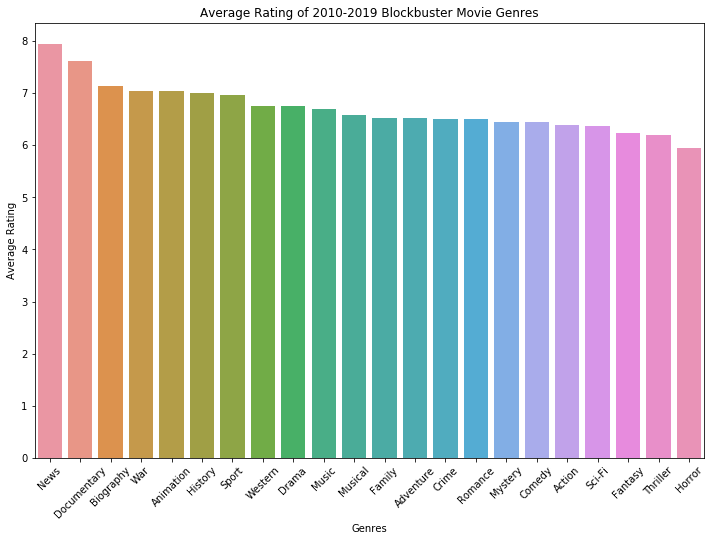

In [318]:
plt.figure(figsize=(12, 8))
ax = plt.subplot()
sns.barplot(data=genre_ratings_blockbuster_movies_multi_year, x='genres', y='average_rating')
plt.xticks(rotation=45)
ax.set_xlabel('Genres')
ax.set_ylabel('Average Rating')
ax.set_title('Average Rating of 2010-2019 Blockbuster Movie Genres')
plt.show()

Hard to separate true blockbuster films through just number of votes - lots of popular indie films present as well.

Would also be interesting to add analysis for box office data, or compare IMDb ratings to Rotten Tomatoes or Metacritic ratings.